<a href="https://colab.research.google.com/github/mymggithub/Stock-Price-Prediction-Machine-Learning/blob/master/Tesla_prediction_AI_with_range.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

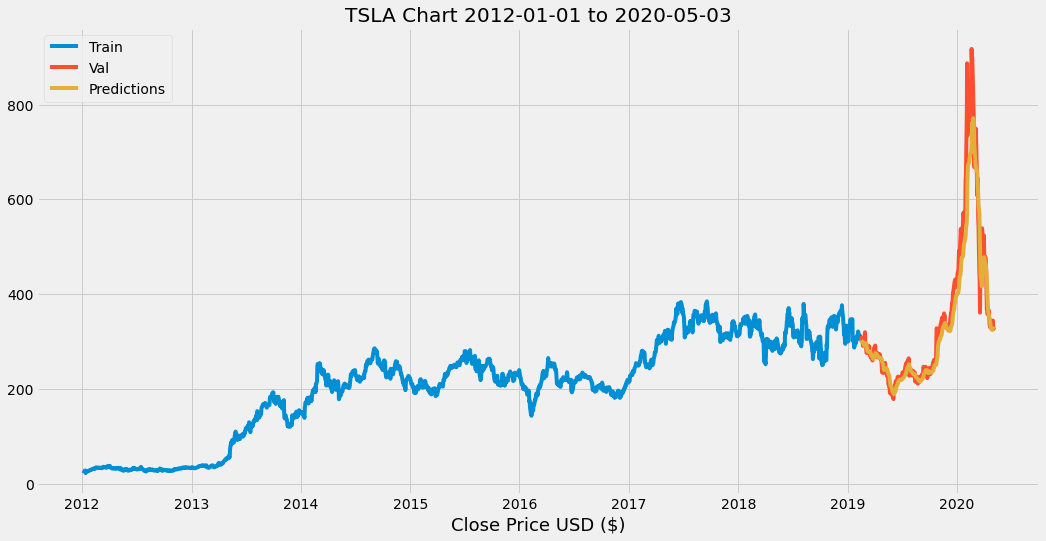

,Close,Predictions,Closed Net Change,Predictioned Net Change,Close vs Predictions
2020-04-23,334.478333,330.768188,-2.074860,-3.169037,1.094177
2020-04-24,335.736267,328.448334,1.257935,-2.319855,3.577789
2020-04-25,342.378418,327.019714,6.642151,-1.428619,8.070770
2020-04-26,326.498871,327.083862,-15.879547,0.064148,-15.943695
2020-04-27,332.788330,325.598022,6.289459,-1.485840,7.775299
2020-04-28,342.373657,324.547638,9.585327,-1.050385,10.635712
2020-04-29,343.349762,325.103027,0.976105,0.555389,0.420715
2020-04-30,344.456329,326.375854,1.106567,1.272827,-0.166260
2020-05-01,332.045532,327.918854,-12.410797,1.542999,-13.953796
2020-05-02,326.503113,327.641846,-5.542419,-0.277008,-5.265411


In [0]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import Dense,LSTM
from tensorflow.python.keras.layers import Dense,LSTM
from tensorflow.python.keras import Sequential
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import datetime

# Google settings
import warnings
warnings.filterwarnings('ignore')

from google.colab import output, auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())
from gspread_dataframe import get_as_dataframe, set_with_dataframe

start_with = '2012-01-01'
future_days = 1
pred_last_close = 0.0
ticker = "TSLA"
epoch = 1
load_file = 'TSLA l10'



next_date = today = datetime.date.today()
next_date_str = today.strftime("%Y-%m-%d %H:%M:%S")
df = web.DataReader(ticker, data_source='yahoo', start=start_with,end=today.strftime("%Y-%m-%d"))

if load_file:
  t = pd.to_datetime(str(df.iloc[-1:].index.values[0]))
  timestring = t.strftime("%Y-%m-%d %-H:%M:%S")
  worksheet = gc.open(load_file).sheet1
  tmp_df = get_as_dataframe(worksheet, parse_dates=True, usecols=[0,1]) #,2,3,4,5
  tmp_df = tmp_df.dropna()
  tmp_df = tmp_df.rename(columns={tmp_df.columns[0]: 'Date'})
  tmp_df = tmp_df.iloc[tmp_df[tmp_df['Date']==timestring].index.values[0]+1:]
  next_date = today = datetime.datetime.strptime(tmp_df["Date"].iloc[-1],"%Y-%m-%d %H:%M:%S")
  tmp_df['Date']= pd.to_datetime(tmp_df['Date']) 
  tmp_df2 = tmp_df.set_index("Date")
  df = pd.concat([df, tmp_df2])

for days_i in range(future_days+1):
  if future_days==0:
    break
  start_time = pd.Timestamp.now()
  if days_i > 0:
    tmp = df
    next_date = today + datetime.timedelta(days=days_i)
    next_date_str = next_date.strftime("%Y-%m-%d %H:%M:%S")
    df = pd.concat([df, pd.DataFrame([pd.Series({"Close":pred_last_close})], index = [datetime.datetime.strptime(next_date_str,"%Y-%m-%d %H:%M:%S")])])
  data = df.filter(['Close'])
  dataset = data.values
  training_data_len = math.ceil( len(dataset) * .85 )
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(dataset)
  train_data = scaled_data[0:training_data_len, :]
  x_train = []
  y_train = []
  for i in range(60 ,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  print()
  print ('Currently running {}: {}/{}'.format(next_date.strftime("%Y-%m-%d"),days_i,future_days))
  model = Sequential()
  model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(LSTM(50, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  verbose = 1
  if epoch>1:
    verbose = 0
  model.fit(x_train, y_train, batch_size=1, epochs=epoch, verbose=verbose)
  test_data = scaled_data[training_data_len - 60: , :]
  x_test = []
  y_test = dataset[training_data_len:, :]
  for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  predictions = model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)
  rsme = np.sqrt( np.mean( predictions - y_test)**2 )
  print ('rsme error: {:f}'.format(rsme))
  train = data[:training_data_len]
  valid = data[training_data_len:]
  valid["Predictions"] = predictions
  df['Close Yesterday'] = df['Close'].shift()
  valid["Closed Net Change"] = df['Close']-df['Close Yesterday']
  df['Predictions Yesterday'] = valid['Predictions'].shift()
  valid["Predictioned Net Change"] = valid['Predictions']-df['Predictions Yesterday']
  valid["Close vs Predictions"] = valid["Closed Net Change"] - valid["Predictioned Net Change"]
  new_df = data
  last_60_days = new_df[-60:].values
  last_60_days_scaled = scaler.transform(last_60_days)
  X_test = []
  X_test.append(last_60_days_scaled)
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  pred_price = model.predict(X_test)
  pred_price = scaler.inverse_transform(pred_price)
  pred_last_close = pred_price[0][0]
  print ('{} Prediction: {:f}'.format(next_date.strftime("%Y-%m-%d"),pred_last_close))
  print('{} [{}] elapse time: {}'.format(next_date.strftime("%Y-%m-%d"),days_i,pd.Timestamp.now()-start_time))
  try:
    if days_i==0:
      sh = gc.create(ticker)
      worksheet = gc.open(ticker).sheet1
    set_with_dataframe(worksheet, valid, include_index=True)
  except:
    print("Might need to re-auth")
    auth.authenticate_user()
    gc = gspread.authorize(GoogleCredentials.get_application_default())
    worksheet = gc.open(ticker).sheet1

output.clear()

# if future_days==0:
#   valid["Predictions"] = valid["Close"]

plt.figure(figsize=(16,8))
plt.title(ticker+" Chart "+start_with+" to "+next_date.strftime("%Y-%m-%d"))
plt.xlabel("Date", fontsize=18)
plt.xlabel("Close Price USD ($)", fontsize=18)
plt.plot(train["Close"])
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Val", "Predictions"], loc="upper left")
plt.show()
valid.tail(future_days+10)

In [0]:
valid.tail(25+10)

,Close,Predictions,Closed Net Change,Predictioned Net Change,Close vs Predictions
2020-03-26,528.159973,438.805969,-11.090027,16.237854,-27.327881
2020-03-27,514.359985,454.929504,-13.799988,16.123535,-29.923523
2020-03-30,502.130005,466.474823,-12.229980,11.545319,-23.775299
2020-03-31,524.000000,472.441376,21.869995,5.966553,15.903442
2020-04-01,481.559998,478.192200,-42.440002,5.750824,-48.190826
2020-04-02,454.470001,476.578674,-27.089996,-1.613525,-25.476471
2020-04-03,480.010010,468.507629,25.540009,-8.071045,33.611053
2020-04-06,477.291443,462.734039,-2.718567,-5.773590,3.055023
2020-04-07,463.192932,458.231354,-14.098511,-4.502686,-9.595825
2020-04-08,427.059113,453.021210,-36.133820,-5.210144,-30.923676
